<a href="https://colab.research.google.com/github/sheldonkemper/bank_of_england/blob/main/notebooks/modelling/LLM_Pipeline_core.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LLM Pipeline**

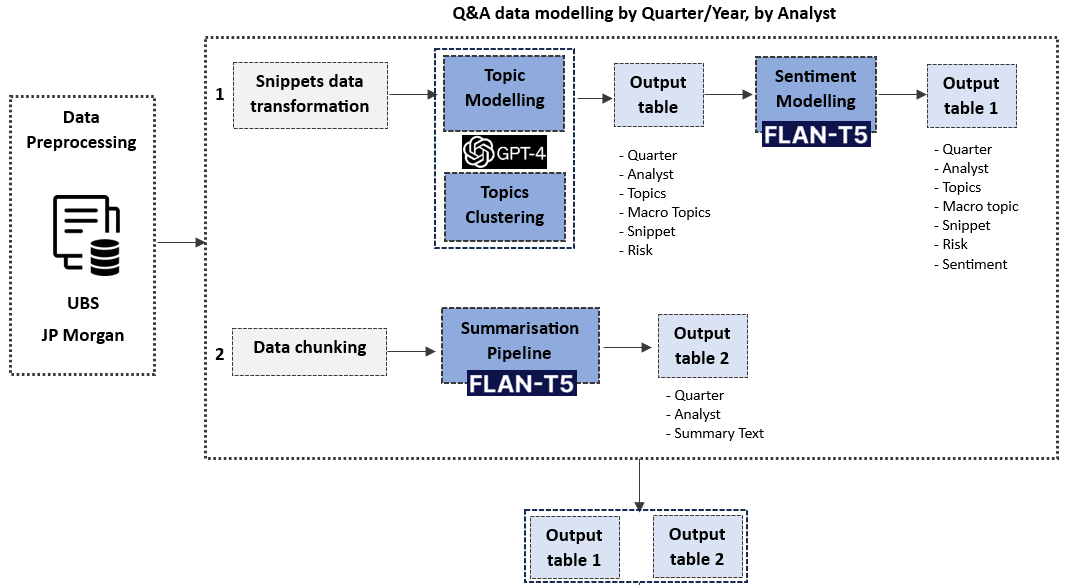

In [ ]:
# Import necessary libraries
import openai
import pandas as pd
import os
import re

# Ensure OpenAI API key is set
openai_api_key = os.getenv("Openai_key")


In [ ]:
############################################
# Step 1: Load CSV Files into DataFrame
############################################

# Load the CSV file (assuming the user uploads it)
input_df = pd.read_csv("/content/drive/MyDrive/BOE/bank_of_england/data/preprocessed_data/ubs_qa_df_preprocessed_ver2.csv")
print("CSV file loaded successfully.")

CSV file loaded successfully.


# Section 1: Topic Modeling

In [ ]:
############################################
# Step 2: Define Function to Extract Topics using GPT-4-Turbo
############################################
print("Defining GPT-4-Turbo function for topic extraction...")

def extract_topics(text):
    """
    This function takes a financial text input and analyzes the topics discussed in the text.
    It returns a list of topics and corresponding sentences that contributed to each topic.
    """
    if pd.isna(text) or text.strip() == "":
        return "No Topic", "No Relevant Sentences"

    prompt = f"""
    Analyze the following financial text and extract distinct topics discussed.
    Provide:
    1. The topic names.
    2. Example sentences that helped you identify the topic.

    Text:
    {text}
    """

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4-turbo",
            messages=[{"role": "user", "content": prompt}]
        )

        result = response["choices"][0]["message"]["content"]

        # Splitting response into topic and description
        if "\n" in result:
            parts = result.split("\n", 1)
            topic = parts[0].strip()
            topic_description = parts[1].strip()
        else:
            topic = result.strip()
            topic_description = "Description not available"

        return topic, topic_description
    except Exception as e:
        return "Error", str(e)

Defining GPT-4-Turbo function for topic extraction...


In [ ]:
############################################
# Step 4: Apply Function to 'Response_cleand' Column
############################################
print("Applying GPT-4-Turbo function on 'Response_cleand' column...")

question_df[['Answer_topic', 'Answer_topic_description']] = question_df['Response_cleaned'].apply(
    lambda x: pd.Series(extract_topics(x))
)

final_df = question_df.copy()
print("Topic extraction for responses completed.")

Applying GPT-4-Turbo function on 'Response_cleand' column...
Topic extraction for responses completed.


In [ ]:
############################################
# Step 5: Save Final DataFrame to CSV
############################################
print("Saving final DataFrame to CSV...")

final_df.to_csv("tqc_topic_model_jpmorgan.csv", index=False)
print("CSV file saved successfully.")

Saving final DataFrame to CSV...
CSV file saved successfully.


In [ ]:
# Function to split topics and expand rows
def split_topics(row):
    topics = re.split(r'\n?\d+\.\s\*\*(.*?)\*\*:', row['Answer_topic_description'])
    topics = [t.strip() for t in topics if t.strip()]  # Remove empty entries
    return pd.DataFrame([{**row, 'Answer_topic_description': t} for t in topics])

# Apply the function to each row and reset the index
expanded_df = pd.concat([split_topics(row) for _, row in final_df.iterrows()], ignore_index=True)

# Display the processed DataFrame
expanded_df

In [ ]:
# Function to extract topics and reformat the row
def extract_topics(row):
    # Splitting based on numbered pattern (1, 2, 3, etc.) while keeping the content
    sections = re.split(r'\n?\d+\.\s', row['Answer_topic_description'])
    sections = [s.strip() for s in sections if s.strip()]  # Remove empty entries

    # Create a new dictionary for the reformatted row
    new_row = row.to_dict()

    # Assign each section to a new numbered column
    for i, section in enumerate(sections):
        new_row[f"Topic_{i+1}"] = section  # Naming columns as Topic_1, Topic_2, etc.

    return new_row

# Apply the function and expand the DataFrame
expanded_df = pd.DataFrame([extract_topics(row) for _, row in final_df.iterrows()])

# Display the processed DataFrame
expanded_df

In [ ]:
############################################
# Step 6: Save Final DataFrame to CSV
############################################
print("Saving final DataFrame to CSV...")

final_df.to_csv("tqc_topic_model_jpmorgan_breakdown.csv", index=False)
print("CSV file saved successfully.")

Saving final DataFrame to CSV...
CSV file saved successfully.


In [ ]:
# Creating DataFrame
df = pd.DataFrame(final_df)

# Function to explode Topic column
def explode_topics(df):
    df = df.copy()
    df["Answer_topic_description"] = df["Answer_topic_description"].str.split(r'\s\d+\. ')
    df["Answer_topic_description"] = df["Answer_topic_description"].apply(lambda x: [i for i in x if i])
    return df.explode("Answer_topic_description", ignore_index=True)

# Applying function
df_exploded = explode_topics(df)

# Displaying the result
df_exploded

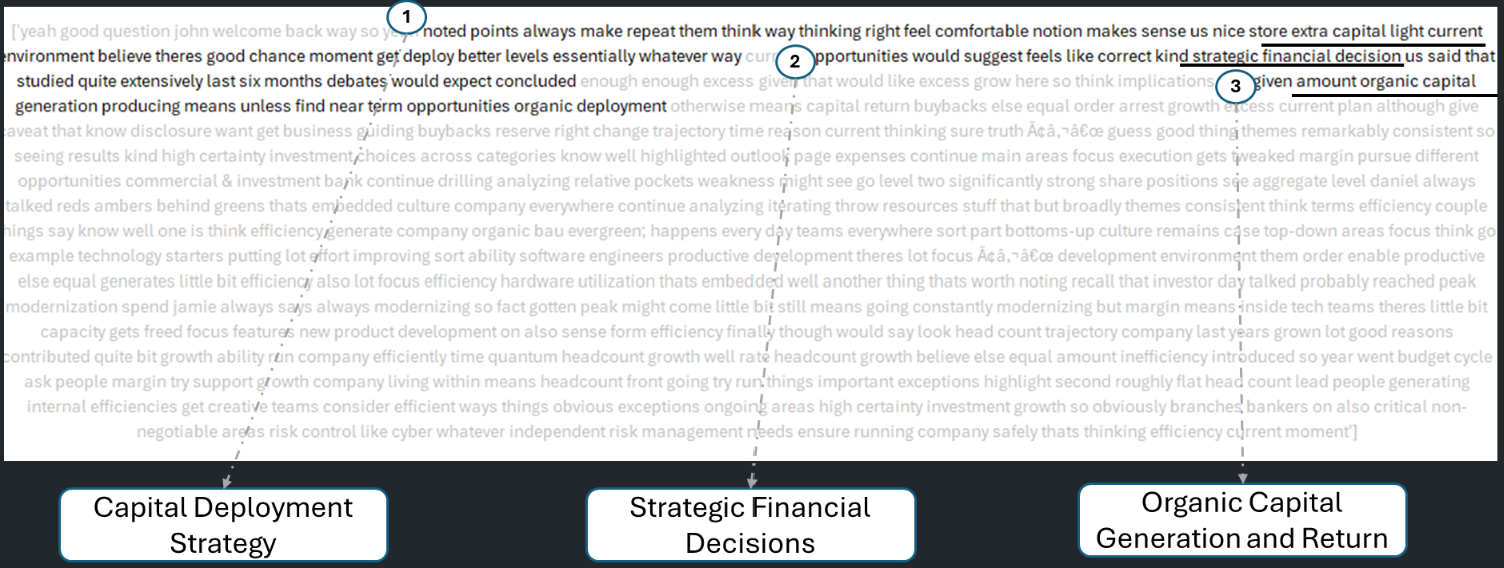

**Objective:**

The topics extracted are micro level topics. These are goods for sentiment analysis but not aligned with summarization model. So, the risk of the topic along with the high level topics are also determined after sentiment run.

**Approach:**

The following parameters are added.

Marco level topics: These are G-SIB assesment criteria. The micro level topics classified through key words of these topics.

High Level topics: These are key topics of any financial institutions. For example, asset, liiability, profit, loos etc.

Risk: The micro topics may be risky such as credit score. The topics are classified into 3 risk categories. These are High, medium and Low.

**Process:**

The GPT-4-Turbo model prompted with role 'Financial Analyst' to perform the above classification based on micro topics.

# Section 2: Classification of risk

In [ ]:
# Function to classify risk using GPT-4-Turbo
def classify_risk(snippet):
    prompt = f"""You are a financial risk assessment model.
    Analyze the following financial snippet and classify the risk level as High, Medium, or Low.
    Only return one of these three words: High, Medium, or Low.

    Financial Snippet: "{snippet}"

    Risk Level:"""

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4-turbo",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=10
        )
        return response["choices"][0]["message"]["content"].strip()
    except Exception as e:
        print(f"Error processing snippet: {e}")
        return "Unknown"


In [ ]:
# Apply function to classify risk
input_df["Risk"] = input_df["Snippet"].astype(str).apply(classify_risk)

# Display first few rows of the updated DataFrame
input_df.head()

# Section 3: Maacro Topics - Classification according to G-SIB crieria

In [ ]:
# Define the topics and associated keywords
topics_keywords = {
    "Cross-jurisdictional claims": "foreign claims, international claims, cross-border claims, local claims in foreign currency, BIS consolidated banking statistics",
    "Cross-jurisdictional liabilities": "foreign liabilities, related offices, BIS consolidated banking statistics, international banking market, local liabilities in local currency",
    "Total exposure": "total assets, total liabilities, risk-weighted assets, leverage ratio, Basel III, capital adequacy, bank exposures",
    "Intra-financial system assets": "lending to financial institutions, securities holdings, reverse repurchase agreements, securities lending, OTC derivatives assets",
    "Intra-financial system liabilities": "deposits by financial institutions, securities issued, repurchase agreements, securities borrowing, OTC derivatives liabilities",
    "Wholesale funding ratio": "wholesale funding, total liabilities, retail deposits, certificates of deposit, debt securities, interbank market",
    "Assets under custody": "custodian bank, financial market infrastructures, institutional investors, asset servicing, fund administration",
    "Payments cleared and settled through payment systems": "payment processing, clearing house, liquidity providers, financial transactions, central counterparties, real-time gross settlement (RTGS)",
    "Values of underwritten transactions in debt and equity markets": "debt issuance, equity issuance, underwriting, primary markets, syndicated loans, investment banking",
    "OTC derivatives notional value": "over-the-counter derivatives, financial contracts, notional value, swaps, options, forwards, derivatives market",
    "Trading book and available-for-sale securities": "financial securities, trading book, mark-to-market, investment portfolios, bond markets, equity markets"
}

In [ ]:
# Function to classify a snippet into a macro topic
def classify_topic(snippet):
    prompt = f"""
    You are a financial classification assistant. Analyze the following financial snippet and classify it into one of the predefined topics.
    Here are the topics and their defining keywords:

    {topics_keywords}

    Financial Snippet: "{snippet}"

    Return ONLY the topic name from the list.
    """

    try:
        response = openai.ChatCompletion.create(
            model="gpt-4-turbo",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=1000
        )
        return response["choices"][0]["message"]["content"].strip()
    except Exception as e:
        print(f"Error processing snippet: {e}")
        return "Total exposure"

In [ ]:
# Apply function to classify Macro Topics
input_df["Macro Topic"] = input_df["Snippet"].astype(str).apply(classify_topic)

# Display first few rows of the updated DataFrame
input_df.head()

Error processing snippet: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)
Error processing snippet: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)


,filename,Quarter,Question,Question_cleaned,Analyst_Bank,Response,Response_cleaned,Executive,Question_topic,Question_topic_description,Topic,Snippet,snippet_sent,Risk,Macro Topic
0,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Capital Requirements,okay thank you capital requirements know situa...,Neutral,Low,Total exposure
1,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Business Scope and Exit,determine scope perimeter activities run parti...,Neutral,Medium,Total exposure
2,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Operational Risk,will course impact op-risk capital charges on,Neutral,High,Total exposure
3,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Communication and Clarity,clarity aspects communicate expect something s...,Neutral,Low,None
4,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti'],### Topics Analysis from Financial Text:,1. **Capital Requirements and Scope of Perimet...,Transaction and Value,merits value accretion creation transaction re...,Neutral,Low,Values of underwritten transactions in debt an...


In [ ]:
import pandas as pd

# Load your classified DataFrame
file_path = "classified_macro_topics.csv"
input_df = pd.read_csv(file_path)

# Function to clean the Macro Topic column
def clean_macro_topic(topic):
    # Remove unwanted characters
    cleaned_topic = topic.replace("'", "").replace('"', "").strip()

    # Check if it has more than 10 words
    if len(cleaned_topic.split()) > 10:
        return "Multi-Topic"

    return cleaned_topic

# Apply the cleaning function
input_df["Macro Topic"] = input_df["Macro Topic"].astype(str).apply(clean_macro_topic)


# Display first few rows of the updated DataFrame
input_df.head()

In [ ]:
# Save the updated DataFrame to a new CSV
output_file_path = "tqc_UBS_classified_macro_topics.csv"
input_df.to_csv(output_file_path, index=False)

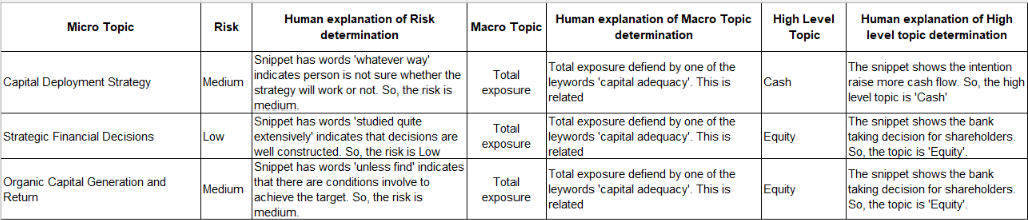

# Section 4: Sentiment analysis with Flan-T5

Flan-T5 (base) was fine-tuned using the Financial Phrasebank external dataset (https://huggingface.co/datasets/takala/financial_phrasebank)

* Financial sentences labelled with polar sentiment
* Chosen subset: full agreement between 8 annotators with adequate knowledge

* **The fine-tuned model's performance was compared to a zero-shot approach using manually ground-truth labelled data:**

Fine-Tuned Model Metrics:
Accuracy: 0.7473684210526316
Weighted F1: 0.7373058694447272
Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.29      0.45        17
     Neutral       0.82      0.88      0.85        68
    Positive       0.35      0.60      0.44        10

    accuracy                           0.75        95
   macro avg       0.72      0.59      0.58        95
weighted avg       0.80      0.75      0.74        95


Zero-Shot Model Metrics:
Accuracy: 0.7578947368421053
Weighted F1: 0.6952293013234842
Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.06      0.11        17
     Neutral       0.77      0.96      0.86        68
    Positive       0.60      0.60      0.60        10

    accuracy                           0.76        95
   macro avg       0.79      0.54      0.52        95
weighted avg       0.80      0.76      0.70        95



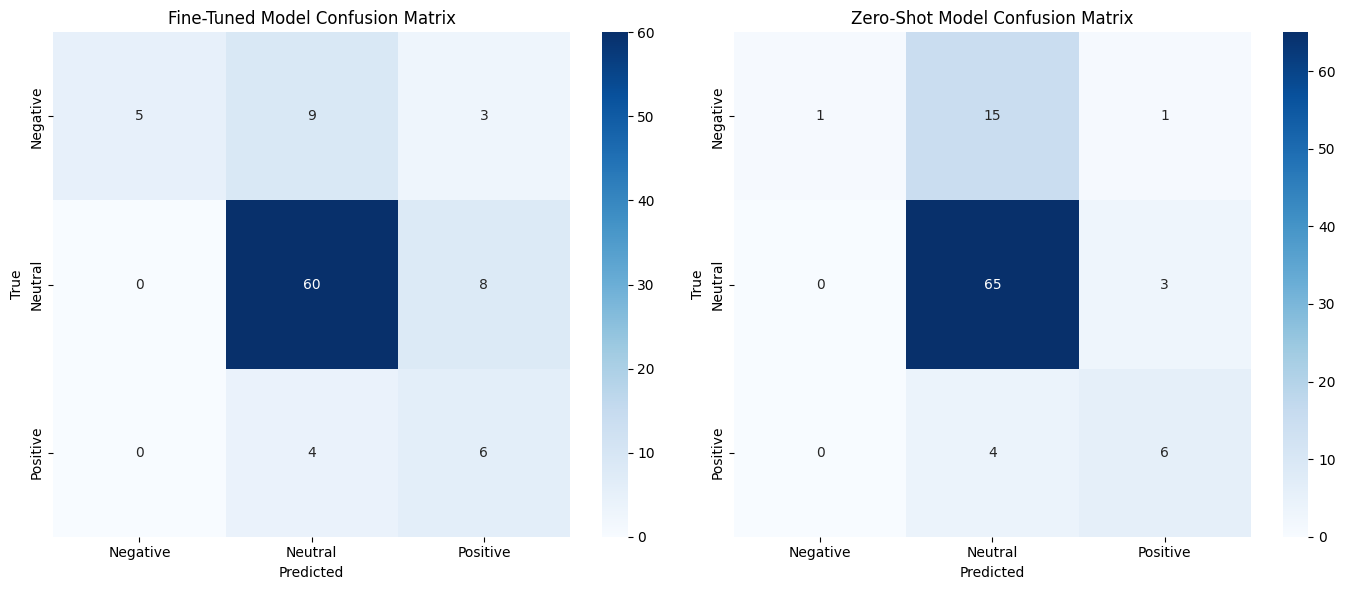

In [ ]:
# Define the target names in the order you expect them
target_names = ["Negative", "Neutral", "Positive"]

# ----------------------------
# Metrics for Fine-Tuned Model
# ----------------------------
accuracy_tuned = accuracy_score(df_manual["ground_label"], df_manual["flan_t5_sentiment_tuned_label"])
f1_tuned = f1_score(df_manual["ground_label"], df_manual["flan_t5_sentiment_tuned_label"], average="weighted")
report_tuned = classification_report(df_manual["ground_label"], df_manual["flan_t5_sentiment_tuned_label"], target_names=target_names)

print("Fine-Tuned Model Metrics:")
print("Accuracy:", accuracy_tuned)
print("Weighted F1:", f1_tuned)
print("Classification Report:\n", report_tuned)

# ----------------------------
# Metrics for Zero-Shot Model
# ----------------------------
accuracy_zero = accuracy_score(df_manual["ground_label"], df_manual["flan_t5_sentiment_zero_shot"])
f1_zero = f1_score(df_manual["ground_label"], df_manual["flan_t5_sentiment_zero_shot"], average="weighted")
report_zero = classification_report(df_manual["ground_label"], df_manual["flan_t5_sentiment_zero_shot"], target_names=target_names)

print("\nZero-Shot Model Metrics:")
print("Accuracy:", accuracy_zero)
print("Weighted F1:", f1_zero)
print("Classification Report:\n", report_zero)

# ----------------------------
# Confusion Matrix Plotting
# ----------------------------
cm_tuned = confusion_matrix(df_manual["ground_label"], df_manual["flan_t5_sentiment_tuned_label"], labels=target_names)
cm_zero = confusion_matrix(df_manual["ground_label"], df_manual["flan_t5_sentiment_zero_shot"], labels=target_names)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix for Fine-Tuned Model
sns.heatmap(cm_tuned, annot=True, fmt="d", cmap="Blues", ax=axes[0],
            xticklabels=target_names, yticklabels=target_names)
axes[0].set_title("Fine-Tuned Model Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# Confusion Matrix for Zero-Shot Model
sns.heatmap(cm_zero, annot=True, fmt="d", cmap="Blues", ax=axes[1],
            xticklabels=target_names, yticklabels=target_names)
axes[1].set_title("Zero-Shot Model Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

* Although overall accuracy was higher for the zero-shot model, the fine-tuned model has a higher weighted F1 score (0.74 vs 0.70).
* The fine-tuned model's negative recall is better (0.29 vs 0.06) - this is important given our context.

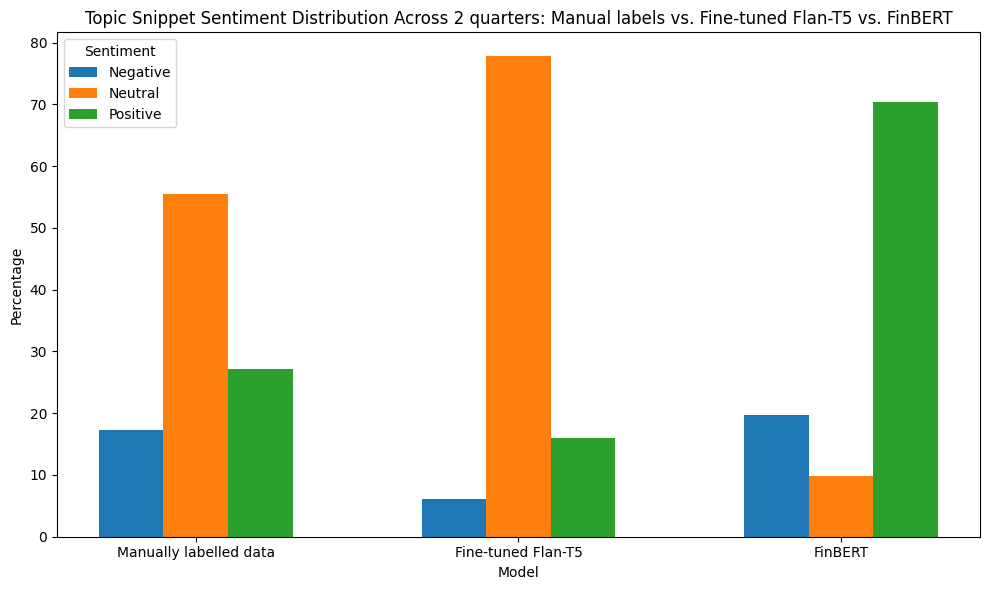

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define sentiment categories
sentiments = ["Negative", "Neutral", "Positive"]

# Compute sentiment proportions for each method
datasets = {
    "Manually labelled data": ground_labelled["manual_label"],
    "Fine-tuned Flan-T5": ground_labelled["snippet_sent"],
    "FinBERT": ground_labelled["finbert_sentiment"]
}

# Create a DataFrame to store proportions
sentiment_proportions = {}

for name, labels in datasets.items():
    counts = labels.value_counts(normalize=True) * 100  # Convert to percentage
    sentiment_proportions[name] = [counts.get(sent, 0) for sent in sentiments]

# Convert to DataFrame for plotting
sentiment_df = pd.DataFrame(sentiment_proportions, index=sentiments)

# Plot grouped bar chart (3 bars per model)
fig, ax = plt.subplots(figsize=(10,6))
bar_width = 0.2  # Width of individual bars
x = np.arange(len(datasets))  # X-axis positions for each group

# Plot bars for each sentiment
for i, sentiment in enumerate(sentiments):
    ax.bar(x + i * bar_width, sentiment_df.loc[sentiment], width=bar_width, label=sentiment)

# Formatting
ax.set_xlabel("Model")
ax.set_ylabel("Percentage")
ax.set_title("Topic Snippet Sentiment Distribution Across 2 quarters: Manual labels vs. Fine-tuned Flan-T5 vs. FinBERT")
ax.set_xticks(x + bar_width)
ax.set_xticklabels(datasets.keys())  # Labels for each dataset (model)
ax.legend(title="Sentiment")
plt.tight_layout()
plt.show()

* The fine-tuned model mimics the sentiment proportions of the ground-truth data more closely than FinBERT.

However, sentiment output for UBS/JPM Q&A topic snippets is majority 'Neutral'
* A limitation - we would like positive and negative sentiment to be as high as possible for insight generation.

Possible explanations:
* Granularity of the topic data
* Preprocessing approach - tone of speaker dimmed by word/punctuation removal.

# Section 6: Summarisation pipeline with Flan-T5large

In [ ]:
!pip install bertopic umap-learn hdbscan sentence-transformers > /dev/null 2>&1
!pip install transformers torch > /dev/null 2>&1
!pip install rouge_score > /dev/null 2>&1
!pip install evaluate > /dev/null 2>&1
!pip install --upgrade protobuf > /dev/null 2>&1
!pip install tensorboard > /dev/null 2>&1
!pip install tensorflow > /dev/null 2>&1

In [ ]:
import time
import torch
from google.colab import drive
import os
import sys
import pandas as pd
import re
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer,Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
import evaluate
from rouge_score import rouge_scorer
from typing import List, Union, Optional
import logging
import tensorflow as tf
import numpy as np
import random

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:

# Load data (questions and answers for JPM and UBS)

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:

path1 = "/content/drive/MyDrive/BOE/bank_of_england/data/preprocessed_data/jp_morgan_qna.csv"

path2 = "/content/drive/MyDrive/BOE/bank_of_england/data/preprocessed_data/ubs_qa_df_preprocessed_ver2.csv"

JP_qna = pd.read_csv(path1)
UBS_qna = pd.read_csv(path2)

In [ ]:
JP_qna = JP_qna[JP_qna["Quarter"] != "1Q23"]
UBS_qna = UBS_qna[UBS_qna["Quarter"] != "1Q23"]

# **Model pipeline**

In [ ]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ----------------------------
# Model Load and Tokenizer
# ----------------------------
class TextSummarizer:
    def __init__(self, model_name: str = "google/flan-t5-large", device: Optional[str] = None):
        """Initialize the summarizer with model and device."""
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        logger.info(f"Using device: {self.device}")

        try:
            self.tokenizer = AutoTokenizer.from_pretrained(model_name)
            self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(self.device)
            logger.info(f"Successfully loaded {model_name}")
        except Exception as e:
            logger.error(f"Error loading model: {str(e)}")
            raise

# ----------------------------
# Text Chunking with overlap
# ----------------------------

    def chunk_text(self,
                  text: Union[str, List[str]],
                  chunk_size: int = 500,
                  overlap: int = 50) -> List[str]:
        """Split text into overlapping chunks."""

        if chunk_size <= 0 or overlap < 0 or overlap >= chunk_size:
            raise ValueError("Invalid chunk_size or overlap parameters")

        try:

            if isinstance(text, list):
                text = " ".join(text)

            if not text.strip():
                return []

            words = text.split()
            chunks = []
            start = 0

            while start < len(words):
                end = min(start + chunk_size, len(words))
                chunk = " ".join(words[start:end])
                chunks.append(chunk)
                start += chunk_size - overlap

            logger.debug(f"Split text into {len(chunks)} chunks")
            return chunks

        except Exception as e:
            logger.error(f"Error in chunk_text: {str(e)}")
            raise

# ----------------------------
# Summarising a single text
# ----------------------------

    def summarize_text(self,
                      text: str,
                      min_new_tokens: int = 100,
                      max_new_tokens: int = 500) -> str:
        """Summarize a single piece of text."""

        if pd.isna(text) or not text.strip():
            logger.warning("Empty or NaN text provided")
            return ""

        try:
            prompt = f"Rewrite the following text into a concise and original summary while maintaining its key ideas: {text}"


            inputs = self.tokenizer(
                prompt,
                return_tensors="pt",
                truncation=True,
                max_length=512
            ).to(self.device)


            with torch.no_grad():
                outputs = self.model.generate(
                    inputs.input_ids,
                    min_new_tokens=min_new_tokens,
                    max_new_tokens=max_new_tokens,
                    num_beams=4,
                    length_penalty=2,
                    no_repeat_ngram_size=3,
                    early_stopping=True,
                    do_sample=False
                )

            summary = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            return summary

        except Exception as e:
            logger.error(f"Error in summarize_text: {str(e)}")
            raise

# ----------------------------
# Summarising long text
# ----------------------------

    def summarize_long_text_2(self,
                          text: Union[str, List[str]],
                          chunk_size: int = 500,
                          overlap: int = 50) -> str:
        """Handle long text summarization."""
        try:
            # Get chunks
            chunks = self.chunk_text(text, chunk_size, overlap)
            if not chunks:
                logger.warning("No valid chunks to summarize")
                return ""

            # Summarize chunks
            chunk_summaries = []
            for i, chunk in enumerate(chunks):
                logger.debug(f"Summarizing chunk {i+1}/{len(chunks)}")
                summary = self.summarize_text(chunk)
                if summary.strip():
                    chunk_summaries.append(summary)

            if not chunk_summaries:
                logger.warning("No valid summaries generated")
                return ""


            if len(chunk_summaries) == 1:
                return chunk_summaries[0]

            # Summarize the combined summaries
            logger.debug("Generating final summary")
            final_summary = self.summarize_text(
                " ".join(chunk_summaries),
                min_new_tokens=150,
                max_new_tokens=300
            )

            return final_summary

        except Exception as e:
            logger.error(f"Error in summarize_long_text: {str(e)}")
            raise


## **Testing the model on a selected analyst and quarter**

### **Analysing John McDonald data Q4-2024 data**

In [ ]:
filtered_df3 = JP_qna[(JP_qna["Analyst"] == 'John McDonald')& (JP_qna["Quarter"] == "4Q24")]


**Summarinsing answsers**

In [ ]:
analyst_text2 = filtered_df2["Response"].tolist()  #### genertaing list for modeling

In [ ]:
# Running the model
try:

    summarizer = TextSummarizer()


    logger.info("Starting summarization of answer")
    answer_summary3 = summarizer.summarize_long_text_2(analyst_text2)


    print("\nSummary of Answer:")
    print(answer_summary3)

except Exception as e:
    logger.error(f"Error during summarization: {str(e)}")
    print(f"An error occurred: {str(e)}")


Summary of Answer:
Daniel: So, yeah, you've noted all the points that we always make so I won't repeat them. And I think the way we're thinking about it right now is that we feel very comfortable with the notion that it makes sense for us to have a nice store of extra capital in light of the current environment. We believe there's a good chance that there will be a moment where we get to deploy it at better levels than the current opportunities would suggest. And so that feels like a correct kind of strategic and financial decision for us. Having said that, having studied it quite extensively over the last six months and have all the debates that you would expect, we've concluded that we do have enough. We have enough excess. And given that, we would like not have the excess grow from here. And that is our current plan, although, I'll give the caveat that, as you know, is in our disclosure, which is we don't want to get in the business of guiding on buybacks.


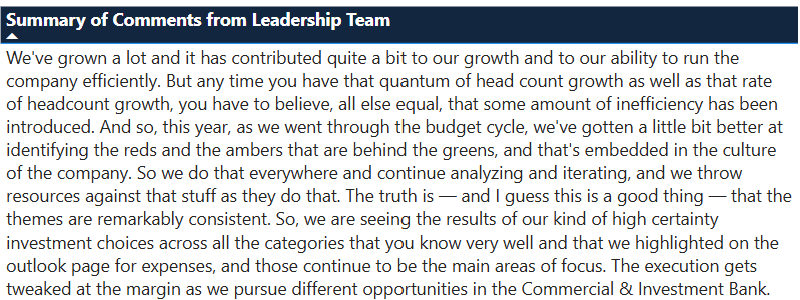

**ROUGE score**

In [ ]:
analyst_text3_str = " ".join(analyst_text2)

# Calculate ROUGE scores
scores2 = scorer.score(analyst_text3_str, answer_summary3)
for key in scores2:
    print(f'{key}: {scores2[key]}')

rouge1: Score(precision=1.0, recall=0.19392033542976939, fmeasure=0.32484635645302895)
rouge2: Score(precision=0.9782608695652174, recall=0.1888772298006296, fmeasure=0.31662269129287596)
rougeL: Score(precision=0.9945945945945946, recall=0.1928721174004193, fmeasure=0.3230904302019315)


Overall ROUGE results have improved after tuning chunks sizes.

# **Applying model to all quarters and to analysts level data**

###**JPMorgan**

In [ ]:
summarizer = TextSummarizer()

summary_data = []

quarter_years = JP_qna["Quarter"].unique()
analysts = JP_qna["Analyst"].unique()

# Loop through each unique Quarter-Year and Analyst
for quarter in quarter_years:
    for analyst in analysts:
        filtered_df = JP_qna[(JP_qna["Quarter"] == quarter) & (JP_qna["Analyst"] == analyst)]

        snippets = filtered_df["Response"].dropna().astype(str).tolist()

        if not snippets:
            # logger.warning(f"No valid snippets found for Quarter-Year: {quarter}, Analyst: {analyst}")
            continue

        # print(type(summarizer))
        # Generate the summary for the text in this Quarter-Year and Analyst
        try:
            summary_text = summarizer.summarize_long_text(snippets)
        except Exception as e:
            logger.error(f"Error summarizing for Quarter {quarter}, Analyst {analyst}: {str(e)}")
            continue

        summary_data.append({"Summary": summary_text, "Quarter": quarter, "Analyst": analyst})

df_summaryJPM = pd.DataFrame(summary_data)

###**UBS**

In [ ]:
summarizer = TextSummarizer()

summary_dataUBS = []

quarter_years = UBS_qna["Quarter"].unique()
analysts = UBS_qna["Analyst_Bank"].unique()

# Loop through each unique Quarter-Year and Analyst
for quarter in quarter_years:
    for analyst in analysts:
        filtered_df = UBS_qna[(UBS_qna["Quarter"] == quarter) & (UBS_qna["Analyst_Bank"] == analyst)]

        snippets = filtered_df["Response"].dropna().astype(str).tolist()

        if not snippets:
            logger.warning(f"No valid snippets found for Quarter-Year: {quarter}, Analyst_Bank: {analyst}")
            continue

        print(type(summarizer))
        # Generate the summary for the text in this Quarter-Year and Analyst
        try:
            summary_text = summarizer.summarize_long_text(snippets)
        except Exception as e:
            logger.error(f"Error summarizing for Quarter {quarter}, Analyst_Bank {analyst}: {str(e)}")
            continue

        summary_dataUBS.append({"Summary": summary_text, "Quarter": quarter, "Analyst_Bank": analyst})

df_summaryUBS = pd.DataFrame(summary_dataUBS)

In [ ]:
#Save CSVs
file_path_1 = "/content/drive/MyDrive/BOE/bank_of_england/data/model_outputs/sent_output/summary_output_JPM.csv"
file_path_2 = "/content/drive/MyDrive/BOE/bank_of_england/data/model_outputs/sent_output/summary_output_UBS.csv"

df_summaryJPM.to_csv(file_path_1, index=False)
df_summaryUBS.to_csv(file_path_2, index=False)

# **Interactive tool to extract key topics and text summary from analysts and leadership conversations**

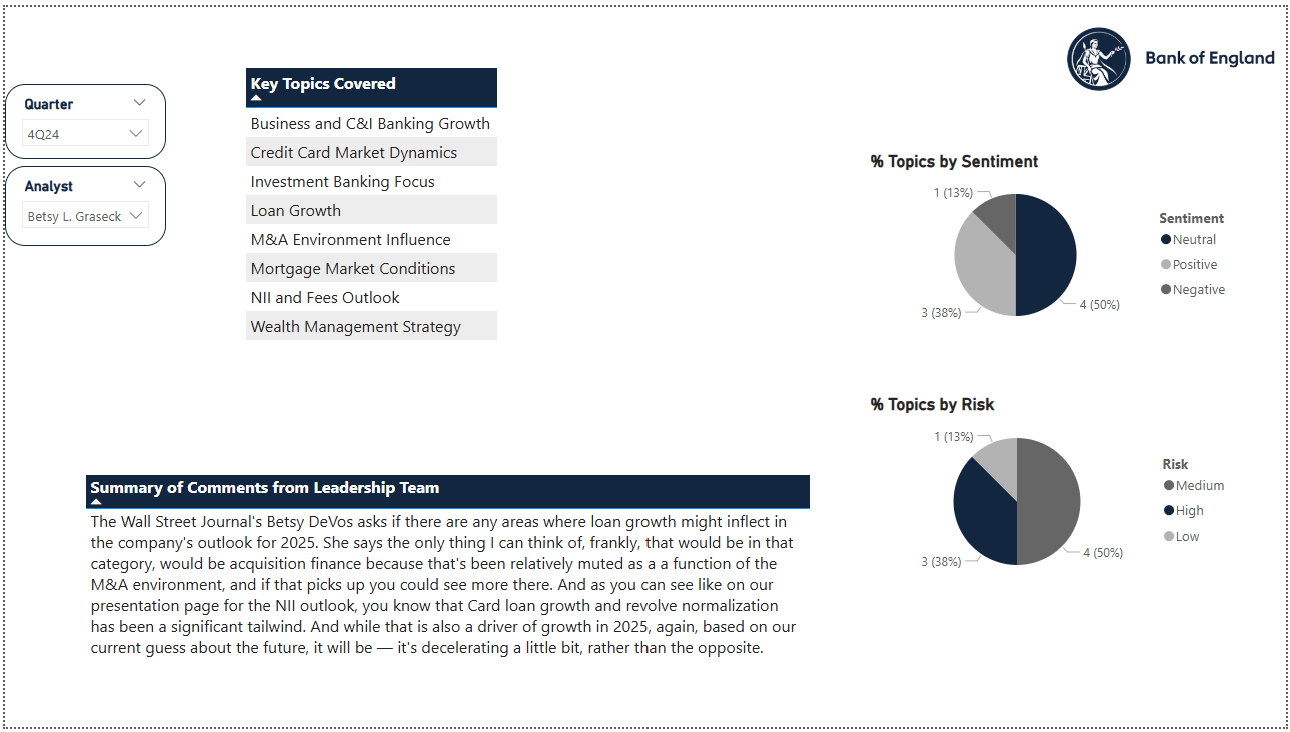